# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2008,2018)    #(1997,2021) # Set years to download

In [2]:
import os
datapath   = os.path.join('../')
print('datapath is set to %s'%datapath)

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly 
# !pip install cufflinks
#!pip install colorspacious
#!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
from Loobos_Toolbox import dateparse, dateparse_Gapfilled, Read_LoobosEddFinal, Read_LooStor, Read_LoodatGapfill, Read_Loobos_halfhourly, Read_Loobos_meteo, Read_Loobos_soil, Read_Loobos_profile

from Ags_model import runAgs, calc_LE

datapath is set to ../


In [3]:
#these next two lines are to prevent re-loading the data. If you want to re-load data, instead comment them out
if not 'progress' in globals(): progress = list()
if not 'dataloaded' in progress:
  # Read files
    df_EC           = Read_LoobosEddFinal    (years,datapath)
    df_Stor         = Read_LooStor           (years,datapath)
    df_Comb         = Read_LoodatGapfill     (years,datapath)
    df_NEE          = Read_Loobos_halfhourly (years,datapath)
    df_meteo        = Read_Loobos_meteo      (years,datapath)
    df_soil         = Read_Loobos_soil       (years,datapath) 
    df_profile      = Read_Loobos_profile    (years,datapath)
    progress.append('dataloaded')

Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
df_EC loaded. Columns in this dataframe:
Index(['Doy', 'Dtime', 'Flx_Tsonic', 'Flx_Lo-H2O', 'Flx_Lo-CO2', 'Qf_Tsonic',
       'Qf_Lo-H2O', 'Qf_Lo-CO2', 'Mea_Windsp', 'Mea_Tsonic', 'Mea_Lo-H2O',
       'Mea_Lo-CO2', 'U-star', 'Z-over-L', 'Wind-Dir', '80PercFlux'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_Stor loaded. Columns in this dataframe:
Index(['Day', 'Time', 'TotalT', 'TotalTflux', 'TotalH2O', 'TotalH2Oflux',
       'TotalCO2', 'TotalCO2flux', 'CO2-2.5m', 'CO2flux-2.5m'],
      dtype='object')
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
df_Comb loaded. Columns in this dataframe:
Index(['Year', 'DoY', 'Hour', 'qcNEE', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil',
       'rH', 'Ustar', 'VPD', 'NEE_orig', 'NEE_f', 'NEE_fqc', 'NEE_fall',
       'NEE_fall_qc', 'NEE_fnum', 'NEE_fsd', 'NEE_fmeth', 'NEE_fwin',
       'Rg_orig', 'Rg_f', 'Rg_fqc', 'Rg_fall', 'Rg_fall_qc', 'Rg_fnum',
       'Rg_fsd', 'Rg_fmeth', 'Rg_fwin', 'H_orig', 'H_f', 'H_fqc', 'H_fall',
       'H_fall_qc', 'H_fnum', 'H_fsd', 'H_fmeth', 'H_fwin', 'LE_orig', 'LE_f',
       'LE_fqc', 'LE_fall', 'LE_fall_qc', 'LE_fnum', 'LE_fsd', 'LE_fmeth',
       'LE_fwin', 'Tair_orig', 'Tair_f', 'Tair_fqc', 'Tair_fall',
       'Tair_fall_qc', 'Tair_fnum

C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2017
Done
df_NEE loaded. Columns in this dataframe:
Index(['NEE_f', 'H_f', 'LE_f', 'Reco_f', 'GPP_f'], dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_meteo loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'S(i)', 'S(o)', 'L(i)', 'L(o)', 'L(i)corr',
       'L(o)corr', 'R(net)', 'PARrefl', 'PAR', 'PARdiff', 'G1', '-q',
       'Te(vaisal)', 'Te-L(i)', 'Te-L(o)', '-u(z)', '-u(dir)', 'H2Olic',
       'CO2lic', 'Vbatt', 'CR10temp', 'P(mast)', 'P(guter)', 'P(field)',
       'SD S(i)', 'SD L(i)', 'SD q', 'SD Te(vaisal)', 'SD u(z)'],
      dtype='object')
Loading ../\Soilmoist\Final\Loosoifinal08.csv...
Loading ../\Soilmoist\Final\Loosoifinal09.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal10.csv...
Loading ../\Soilmoist\Final\Loosoifinal11.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal12.csv...
Loading ../\Soilmoist\Final\Loosoifinal13.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal14.csv...
Loading ../\Soilmoist\Final\Loosoifinal15.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal16.csv...
Loading ../\Soilmoist\Final\Loosoifinal17.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_soil loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'SM-Lit', 'SM-003', 'SM-020', 'SM-050', 'SM-100',
       'ST-Lit', 'ST-003', 'ST-020', 'ST-050', 'ST-100', 'T-bole', 'Temp200',
       'Temp201', 'Temp202', 'Temp203', 'Temp204', 'Temp205', 'Temp206',
       'Temp207'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
df_profile loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'VaiVPtop', 'VaiVPmid', 'Vtemptop', 'Vtempmid',
       'VecWStop', 'VecWSmid', 'Pressure', 'H2Olevel1', 'H2Olevel2',
       'H2Olevel3', 'H2Olevel4', 'H2Olevel5', 'CO2level1', 'CO2level2',
       'CO2level3', 'CO2level4', 'CO2level5', 'H2Ocal', 'CO2cal'],
      dtype='object')


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


In [4]:
# Make filter for GPP orginial data and not gapfilled
#General filters
I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))
#t = df_profile.index                                          
#time = (t < np.datetime64('2013-05-08')) | (t > np.datetime64('2013-06-01'))

# Filter for CO2 data
CO2 = (df_profile['CO2level1'] > 300)

# Filter for L(o)corr data
Locorr= (df_meteo['L(o)corr']>0) 

# Filter for VPD data
VPD = (df_Comb['VPD']>=0)

# Filter for U-star
Ustar = (df_EC['U-star']>=0)

# Combine all filters
filter = I & CO2 & Locorr & VPD & Ustar

#Column 'CO2' is input from df_profile
#df_profile_CO2 = df_profile[CO2]
#df_profile_filter = df_profile_CO2[I]
df_profile_filter = df_profile[filter]

#Column 'L(o)corr' and 'PAR' are inputs from df_meteo
#df_meteo_CO2 = df_meteo[CO2]
#df_meteo_filter = df_meteo_CO2[I]
df_meteo_filter = df_meteo[filter]

#Columns 'VPD' and 'Tair' are inputs from df_Comb
#df_Comb_CO2 = df_Comb[CO2]
#df_Comb_filter = df_Comb_CO2[I]
df_Comb_filter = df_Comb[filter]

# Columns 'Mea_Windsp' and 'U-star' are inputs from df_EC
#df_EC_CO2 = df_EC[CO2]
#df_EC_filter = df_EC_CO2[I]
df_EC_filter = df_EC[filter]

### Run A-gs model

In [11]:
# Run A-gs model

an_final_10,an_umol_10,rs_10, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=1.0)
an_final_8,an_umol_8,rs_8, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.8)

df_Comb_filter2 = df_Comb_filter.copy()
df_Comb_filter2['VPD']=df_Comb_filter2['VPD']*1.1

an_final_10a,an_umol_10a,rs_10a, ra_a = runAgs(df_profile_filter,df_Comb_filter2,df_meteo_filter,df_EC_filter,fstr=1.0)
an_final_8a,an_umol_8a,rs_8a, ra_a = runAgs(df_profile_filter,df_Comb_filter2,df_meteo_filter,df_EC_filter,fstr=0.8)

df_Comb_filter3 = df_Comb_filter.copy()
df_Comb_filter3['VPD']= df_Comb_filter3['VPD']*0.2

an_final_10b,an_umol_10b,rs_10b, ra_b = runAgs(df_profile_filter,df_Comb_filter3,df_meteo_filter,df_EC_filter,fstr=1.0)
an_final_8b,an_umol_8b,rs_8b, ra_b = runAgs(df_profile_filter,df_Comb_filter3,df_meteo_filter,df_EC_filter,fstr=0.8)



#an_final_10,an_umol_10,rs_10, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=1.0)
#an_final_8,an_umol_8,rs_8, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.8)
#an_final_6,an_umol_6,rs_6, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.6)
#an_final_4,an_umol_4,rs_4, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.4)
#an_final_2,an_umol_2,rs_2, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.2)


<Axes: >

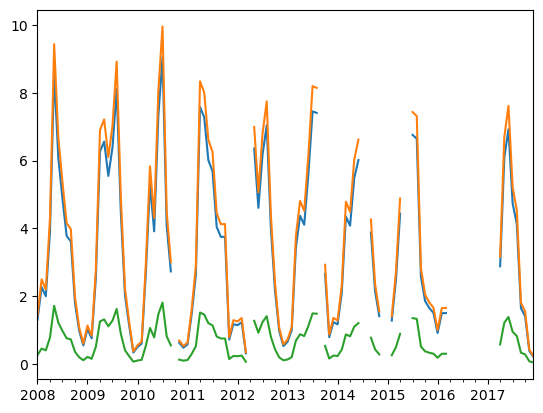

In [12]:
df_Comb_filter.resample("M").mean()['VPD'].plot()
df_Comb_filter2.resample("M").mean()['VPD'].plot()
df_Comb_filter3.resample("M").mean()['VPD'].plot()

<Axes: >

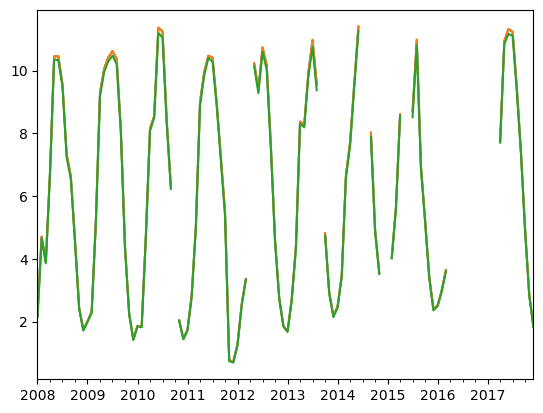

In [13]:
an_umol_8.resample("M").mean().plot()
an_umol_8a.resample("M").mean().plot()
an_umol_8b.resample("M").mean().plot()

## Calcuate ET

### Assemble dataframe 'df_ET' that will hold output and fill with inputs

In [14]:
def init_ETframe(rs_series):
    df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
    #convert Pressure from hPa to kPa 
    df_ET['p_kPa']=df_ET['Pressure']/10
    df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
    df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa
    df_ET['rs']=rs_series.to_frame(name="rs")
    df_ET['ra']=ra.to_frame(name="ra")
    return df_ET

In [15]:
df_ET_10=init_ETframe(rs_10)
df_ET_8=init_ETframe(rs_8)
#df_ET_6=init_ETframe(rs_6)
#df_ET_4=init_ETframe(rs_4)
#df_ET_2=init_ETframe(rs_2)

In [16]:
df_ET_10=calc_LE(df_ET_10)
df_ET_8=calc_LE(df_ET_8)
#df_ET_6=calc_LE(df_ET_6)
#df_ET_4=calc_LE(df_ET_4)
#df_ET_2=calc_LE(df_ET_2)

In [ ]:
#df_ET_10['L(o)_corr'].resample('M').mean().plot(label='mine',legend='y')
#df_meteo_filter['L(o)corr'].resample('M').mean().plot(label='dataset',legend='y')

<Axes: >

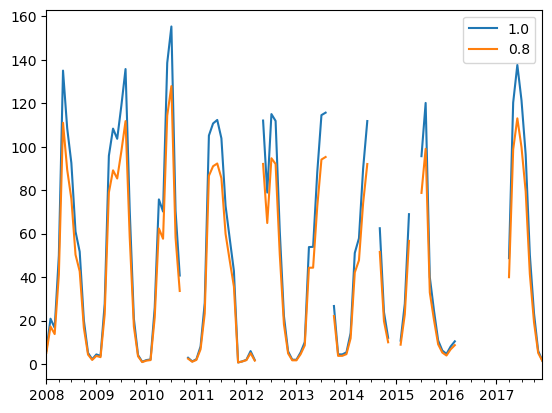

In [14]:
df_ET_10['ET_VPD'].resample('M').mean().plot(label="1.0",legend='yes')
df_ET_8['ET_VPD'].resample('M').mean().plot(label="0.8",legend='yes')
#df_ET_6['ET_VPD'].resample('M').mean().plot(label="0.6",legend='yes')
#df_ET_4['ET_VPD'].resample('M').mean().plot(label="0.4",legend='yes')
#df_ET_2['ET_VPD'].resample('M').mean().plot(label="0.2",legend='yes')
#df_test['LE'].resample('M').mean().plot(label='measured',legend='yes')

### calculate ET

In [15]:
#df_ET_10=calc_LE(df_ET,rs_10,ra_10)
#df_ET_8=calc_LE(df_ET,rs_8,ra_8)
#df_ET_6=calc_LE(df_ET,rs_6,ra_6) 
#df_ET_4=calc_LE(df_ET,rs_4,ra_4)
#df_ET_2=calc_LE(df_ET,rs_2,ra_2)

NameError: name 'df_ET' is not defined

In [20]:
#df_ET_10['ET_VPD'].resample("M").mean().plot()
#measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].resample('M').mean()
#measured_data.plot(legend="measured")

I_filter = ((df_Comb['GPP_fqc']==0)&(df_Comb['LE']>0)&(df_Comb['VPD'] > 0))

#VPD_filter = (df_Comb['VPD'] > 0)
df_test=df_Comb[I_filter]

#df_test['LE'].resample('M').mean().plot()
#df_Comb['LE'].resample('M').mean().plot()

## Correlation plots

In [21]:
#df_Comb_filter['GPP_f'].plot()

### sens analsis

slope, intercept, R2: 0.9994250578922564 0.008449333709059204 0.9999961679065057


Text(0, 0.5, 'Hour')

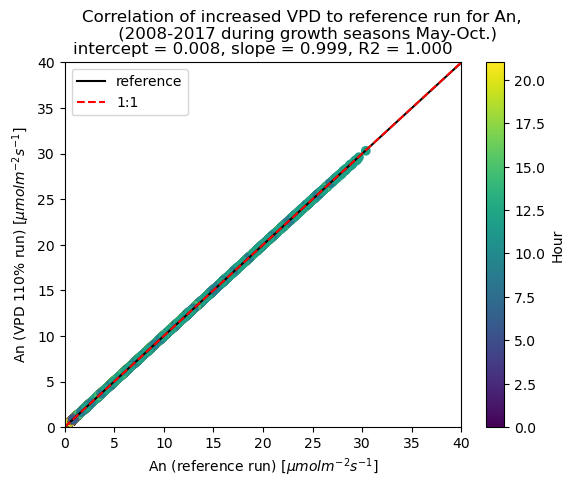

In [20]:
start='2008-05-01 00:00'
end='2018-08-30 00:00'

sim_data_1=an_umol_8.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_1=sim_data_1.dropna() #eliminate NaN entries created by the .loc slice
sim_data_2=an_umol_8a.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_2=sim_data_2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_2=sim_data_2.rename('sim_data_2') #turn into a named series so it works with df.merge() properly

#measured_data=df_Comb_filter['GPP_f'].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
#measured_data=measured_data.dropna()

df_tmp1 = pd.DataFrame()
df_tmp1['sim_data_1']=sim_data_1
df_tmp1=df_tmp1.merge(sim_data_2, how='inner',left_index=True, right_index=True)

df_tmp1

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_tmp1['sim_data_1'], df_tmp1['sim_data_2'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('slope, intercept, R2:', slope1, intercept1, r_value1**2)

fig,ax = plt.subplots()
#p1=ax.scatter(df_tmp1['GPP_f'],df_tmp1['sim_data_1'],c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p1=ax.scatter(df_tmp1['sim_data_1'],df_tmp1['sim_data_2'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept1),slope=slope1,c='black',label='reference')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(0,40)
ax.set_xlim(0,40)
ax.set_xlabel(r'An (reference run) [$\mu molm^{-2}s^{-1}$]')
ax.set_ylabel(r'An (VPD 110% run) [$\mu molm^{-2}s^{-1}$]')
fig.suptitle('Correlation of increased VPD to reference run for An, \n (2008-2017 during growth seasons May-Oct.)')
ax.set_title('intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept1,slope1,r_value1**2))
ax.legend(loc='upper left')
fig.subplots_adjust(top=0.87) #fix the top margin text overlap  
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')

slope, intercept, R2: 0.9953167309753785 -0.06216349148254352 0.9997525371278333


Text(0, 0.5, 'Hour')

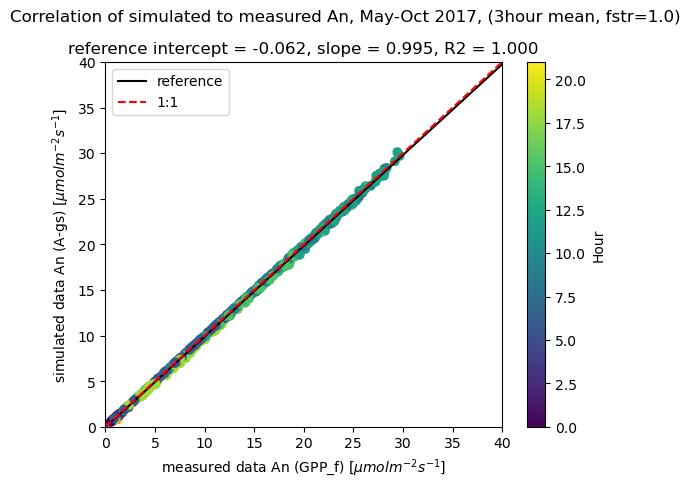

In [18]:
start='2017-05-01 00:00'
end='2017-08-30 00:00'

sim_data_1=an_umol_8.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_1=sim_data_1.dropna() #eliminate NaN entries created by the .loc slice
sim_data_2=an_umol_8b.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_2=sim_data_2.dropna() #eliminate NaN entries created by the .loc slice
sim_data_2=sim_data_2.rename('sim_data_2') #turn into a named series so it works with df.merge() properly

#measured_data=df_Comb_filter['GPP_f'].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
#measured_data=measured_data.dropna()

df_tmp1 = pd.DataFrame()
df_tmp1['sim_data_1']=sim_data_1
df_tmp1=df_tmp1.merge(sim_data_2, how='inner',left_index=True, right_index=True)

df_tmp1

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_tmp1['sim_data_1'], df_tmp1['sim_data_2'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('slope, intercept, R2:', slope1, intercept1, r_value1**2)

fig,ax = plt.subplots()
#p1=ax.scatter(df_tmp1['GPP_f'],df_tmp1['sim_data_1'],c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p1=ax.scatter(df_tmp1['sim_data_1'],df_tmp1['sim_data_2'],marker='o',c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept1),slope=slope1,c='black',label='reference')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(0,40)
ax.set_xlim(0,40)
ax.set_xlabel(r'measured data An (GPP_f) [$\mu molm^{-2}s^{-1}$]')
ax.set_ylabel(r'simulated data An (A-gs) [$\mu molm^{-2}s^{-1}$]')
fig.suptitle('Correlation of simulated to measured An, May-Oct 2017, (3hour mean, fstr=1.0)')
ax.set_title('reference intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept1,slope1,r_value1**2))
ax.legend(loc='upper left')
fig.subplots_adjust(top=0.87) #fix the top margin text overlap  
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')

### Old version (wrong)

slope, intercept, R2: 0.9490427068879173 1.9807932269294497 0.8152987938142742
slope, intercept, R2: 1.0266578093066292 2.270838555715665 0.8147297569608091


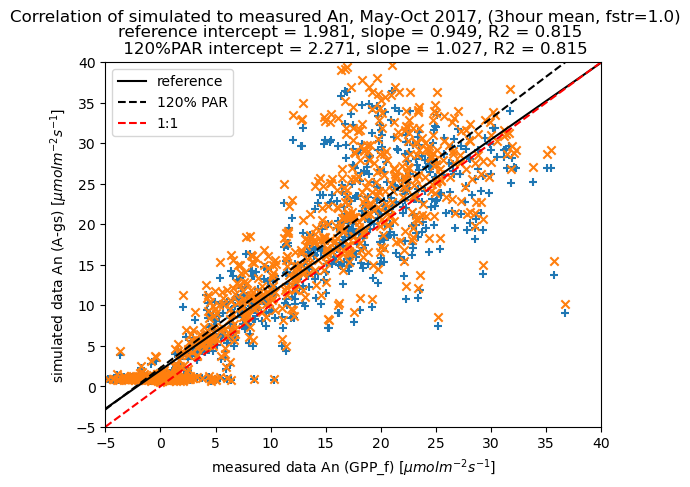

In [74]:
start='2017-05-01 00:00'
end='2017-08-30 00:00'

sim_data_1=an_umol_10.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_1=sim_data_1.dropna() #eliminate NaN entries created by the .loc slice
sim_data_2=an_umol_10b.loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
sim_data_2=sim_data_2.dropna() #eliminate NaN entries created by the .loc slice

measured_data=df_Comb_filter['GPP_f'].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.dropna()

df_tmp1 = pd.DataFrame()
df_tmp1['sim_data_1']=sim_data_1
df_tmp1=df_tmp1.merge(measured_data, how='inner',left_index=True, right_index=True)

slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_tmp1['GPP_f'], df_tmp1['sim_data_1'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('slope, intercept, R2:', slope1, intercept1, r_value1**2)

df_tmp2 = pd.DataFrame()
df_tmp2['sim_data_2']=sim_data_2
df_tmp2=df_tmp2.merge(measured_data, how='inner',left_index=True, right_index=True)

slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(df_tmp2['GPP_f'], df_tmp2['sim_data_2'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('slope, intercept, R2:', slope2, intercept2, r_value2**2)

fig,ax = plt.subplots()
#p1=ax.scatter(df_tmp1['GPP_f'],df_tmp1['sim_data_1'],c=df_tmp1.index.hour,cmap='viridis') #scatter(x,y)
p1=ax.scatter(df_tmp1['GPP_f'],df_tmp1['sim_data_1'],marker='+') #scatter(x,y)
p2=ax.scatter(df_tmp2['GPP_f'],df_tmp2['sim_data_2'],marker='x') #scatter(x,y)
ax.axline((0.0,intercept1),slope=slope1,c='black',label='reference')
ax.axline((0.0,intercept2),slope=slope2,c='black',linestyle='dashed',label='120% PAR')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-5,40)
ax.set_xlim(-5,40)
ax.set_xlabel(r'measured data An (GPP_f) [$\mu molm^{-2}s^{-1}$]')
ax.set_ylabel(r'simulated data An (A-gs) [$\mu molm^{-2}s^{-1}$]')
fig.suptitle('Correlation of simulated to measured An, May-Oct 2017, (3hour mean, fstr=1.0)')
ax.set_title('reference intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept1,slope1,r_value1**2)+' \n 120%PAR intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept2,slope2,r_value2**2))
ax.legend(loc='upper left')
fig.subplots_adjust(top=0.87) #fix the top margin text overlap
#cbar=plt.colorbar(p1,ax=ax)
#cbar.ax.set_ylabel('Hour')

In [ ]:
#check what the R2 value is month-wise for certain years

for year in [2017, 2018]:
    for month in [4,5,6,7,8]:
        
        start='{}-0{}-01 00:00'.format(year, month)
        end='{}-0{}-01 00:00'.format(year, month+1)
        
        sim_data=an_umol.loc[an_umol>0].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
        sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
        measured_data=df_Comb['GPP_f'].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
        measured_data=measured_data.dropna()
        
        df_tmp = pd.DataFrame()
        df_tmp['sim_data']=sim_data
        
        df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['GPP_f'], df_tmp['sim_data'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
        print('{}-0{}-01 -'.format(year, month),'{}-0{}-01'.format(year, month+1),' R2: {:.3f}'.format(r_value**2))


In [ ]:
#def p_dailysum(df):
#    for idx,row in df.iterrows():
#        #calc precipitation sum from 00:00 to 23:59
#        start_day=np.datetime64(str(idx.date())+ ' 00:00')
#        end_day=np.datetime64(str(idx.date())+ ' 23:30')
#        df.loc[idx,'daily_prec']=df.loc[start_day:end_day ,'P(mast)'].sum() #iloc[row, column]
#return df

In [ ]:
#old way, deprecated (takes long due to .iterrows() )
#df_ET_1=p_dailysum(df_ET)

In [ ]:
# Add in precipitation last 3h and 24 hour values so it can be used for filtering
df_ET_1=df_ET.copy()
df_tmp=df_ET_1.groupby(pd.Grouper(freq='D'))[['P(mast)']].sum()
df_ET_1['daily_prec']=df_tmp.resample('30min').ffill()
df_ET_1['last3h_prec']=df_ET_1['P(mast)'].rolling('3H').sum()
df_ET_1['last24h_prec']=df_ET_1['P(mast)'].rolling('24H').sum()
df_ET_1['last2day_prec']=df_ET_1['P(mast)'].rolling('48H').sum()
df_ET_1['last3day_prec']=df_ET_1['P(mast)'].rolling('72H').sum()
#testing
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','daily_prec'].plot()
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','last3h_prec'].plot()
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','last24h_prec'].plot()
df_ET_1.loc['2017-04-15 00:00':'2017-04-30 00:00','last3day_prec'].plot()

In [77]:
#re-draw better correlation plot (longer dataset)
start='2017-04-01 00:00'
end='2017-07-30 00:00'

#new filter
sim_data = df_ET_1.loc[start:end,('ET_VPD','last24h_prec','last3day_prec')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0]
sim_data= sim_data.resample('1H').mean()
sim_data=sim_data.dropna()

measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('1H').mean()#.between_time("6:00", "9:00")
measured_data=measured_data.dropna()
   
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp.index.hour,cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-10,175)
ax.set_xlim(-10,175)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Oct 2017, (1hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Hour')

NameError: name 'df_ET_1' is not defined

In [ ]:
#re-draw better correlation plot (plot leaf temperature)
start='2017-04-14 00:00'
end='2017-08-30 00:00'

#new filter
sim_data = df_ET_1.loc[start:end,('ET_VPD','last3day_prec','T_sfc_C')]
sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
sim_data= sim_data.resample('3H').mean()
sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()
measured_data=measured_data.dropna()

#df_tmp = pd.DataFrame()
df_tmp=sim_data.copy()
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)

fig,ax = plt.subplots()
p1=ax.scatter(df_tmp['LE'],df_tmp['ET_VPD'],c=df_tmp['T_sfc_C'],cmap='viridis') #scatter(x,y)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')
ax.set_ylim(-10,175)
ax.set_xlim(-10,175)
ax.set_xlabel(r'measured data LE (EC) [Wm$^{-2}$]')
ax.set_ylabel(r'simulated data LE (A-gs) [Wm$^{-2}$]')
fig.suptitle('Correlation of simulated to measured LE. April-Oct 2017, (3hour mean, 00:00-23:59) \n intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.set_title('(Only days on which daily  sum of Precip. is 0)')
ax.legend(loc='upper left')
cbar=plt.colorbar(p1,ax=ax)
cbar.ax.set_ylabel('Temp [oC]')

#### quick check R2 for different months

In [ ]:
#check what the R2 value is month-wise for certain years
#USING THE NEW FUNCTION p_dailysum

for year in [2017, 2018]:
    for month in [4,5,6,7,8]:
         
        start='{}-0{}-01 00:00'.format(year, month)
        end='{}-0{}-01 00:00'.format(year, month+1)

        
        sim_data = df_ET_1.loc[start:end,('ET_VPD','last3day_prec')]
        sim_data = sim_data.loc[sim_data['last3day_prec']==0.0]
        sim_data= sim_data.resample('3H').mean()#.between_time("11:00", "18:00")
        sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
        measured_data=df_Comb['LE'].loc[df_Comb['LE']>0].loc[start:end].resample('3H').mean()#.between_time("11:00", "18:00")
        measured_data=measured_data.dropna()
        
        #df_tmp = pd.DataFrame()
        df_tmp=sim_data.copy()
        df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)
        #print(df_tmp)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp['LE'], df_tmp['ET_VPD'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
        print('{}-0{}-01 -'.format(year, month),'{}-0{}-01'.format(year, month+1),'Slope:{:.3f} R2: {:.3f}'.format(slope,r_value**2))
